# Writing like Shakespeare

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/luisangelmendozavelasco.github.io/blob/master/_portfolio/Deep_Learning_Specialization/portfolio-8.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

**Objective**: Implement a Shakespeare poem generator using a Long Short-Term Memory network.

A [Long Short-Term Memory (LSTM)](https://en.wikipedia.org/wiki/Long_short-term_memory) network is a type of Recurrent Neural Network (RNN) designed to handle the vanishing gradient problem and learn long-term dependencies in sequential data. LSTMs have become a fundamental component in many deep learning applications, including natural language processing, speech recognition, and time series forecasting.

## Import libraries

In [1]:
import numpy as np
from keras import Sequential, Input, layers, initializers, callbacks
from datetime import datetime
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

2025-01-04 12:51:21.462024: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736016681.486617  125179 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736016681.493300  125179 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-04 12:51:21.517326: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Download the dataset

In [2]:
!wget -nc --progress=bar:force:noscroll https://raw.githubusercontent.com/LuisAngelMendozaVelasco/Deep_Learning_Specialization/main/Sequence_Models/Week1/Labs/data/shakespeare.txt -P /tmp

File '/tmp/shakespeare.txt' already there; not retrieving.



## Load the dataset

In [3]:
with open('/tmp/shakespeare.txt', encoding='utf-8') as f:
    text = f.read().lower()

chars = sorted(list(set(text)))
print('Number of unique characters in the dataset:', len(chars))
print("\nText:\n", text[:1000] + "...")

Number of unique characters in the dataset: 38

Text:
 the sonnets

by william shakespeare

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou contracted to thine own bright eyes,
feed'st thy light's flame with self-substantial fuel,
making a famine where abundance lies,
thy self thy foe, to thy sweet self too cruel:
thou that art now the world's fresh ornament,
and only herald to the gaudy spring,
within thine own bud buriest thy content,
and tender churl mak'st waste in niggarding:
pity the world, or else this glutton be,
to eat the world's due, by the grave and thee.

when forty winters shall besiege thy brow,
and dig deep trenches in thy beauty's field,
thy youth's proud livery so gazed on now,
will be a tattered weed of small worth held:  
then being asked, where all thy beauty lies,
where all the treasure of thy lusty days;
to say within thine own deep sunk

## Create the training set

In [4]:
def build_data(text, Tx=40, stride=3):
    """
    Create a training set by scanning a window of size Tx over the text corpus, with stride 3.
    
    Arguments:
    text -- string, corpus of Shakespearian poem
    Tx -- sequence length, number of time-steps (or characters) in one training example
    stride -- how much the window shifts itself while scanning
    
    Returns:
    X -- list of training examples
    Y -- list of training labels
    """
    
    X = []
    Y = []

    for i in range(0, len(text) - Tx, stride):
        X.append(text[i: i + Tx])
        Y.append(text[i + Tx])
    
    print('Number of training examples:', len(X))
    
    return X, Y

def vectorization(X, Y, n_x, char_indexes, Tx=40):
    """
    Convert X and Y (lists) into arrays to be given to a recurrent neural network.
    
    Arguments:
    X -- 
    Y -- 
    Tx -- integer, sequence length
    
    Returns:
    x -- array of shape (m, Tx, len(chars))
    y -- array of shape (m, len(chars))
    """
    
    m = len(X)
    x = np.zeros((m, Tx, n_x), dtype=bool)
    y = np.zeros((m, n_x), dtype=bool)

    for i, sentence in enumerate(X):
        for t, char in enumerate(sentence):
            x[i, t, char_indexes[char]] = 1

        y[i, char_indexes[Y[i]]] = 1
        
    return x, y 

In [5]:
Tx = 40
char_indexes = dict((c, i) for i, c in enumerate(chars))
indexes_char = dict((i, c) for i, c in enumerate(chars))
X, Y = build_data(text, Tx, stride=3)
x, y = vectorization(X, Y, n_x=len(chars), char_indexes=char_indexes) 

Number of training examples: 31412


## Build a Long Short-Term Memory network

In [6]:
model = Sequential([Input(shape=(40, 38)),
                    layers.LSTM(units=128, recurrent_activation="hard_sigmoid", kernel_initializer=initializers.VarianceScaling(mode="fan_avg", distribution="uniform"), return_sequences=True),
                    layers.Dropout(rate=0.5),
                    layers.LSTM(units=128, recurrent_activation="hard_sigmoid", kernel_initializer=initializers.VarianceScaling(mode="fan_avg", distribution="uniform")),
                    layers.Dropout(rate=0.5),
                    layers.Dense(units=38, activation="linear", kernel_initializer=initializers.VarianceScaling(mode="fan_avg", distribution="uniform")),
                    layers.Activation(activation="softmax")])

model.summary()

I0000 00:00:1736016685.893714  125179 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1855 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 40, 128)        │        85,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │         4,902 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 38)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 221,990 (867.15 KB)

 Trainable params: 221,990 (867.15 KB)

 Non-trainable params: 0 (0.00 B)

## Create a custom callback

In [7]:
class CustomVerbose(callbacks.Callback):
    def __init__(self, epochs_to_show):
        self.epochs_to_show = epochs_to_show

    def on_epoch_begin(self, epoch, logs=None):
        if epoch in self.epochs_to_show:
            self.epoch_start_time = datetime.now()

    def on_epoch_end(self, epoch, logs=None):
        if epoch in self.epochs_to_show:
            self.epoch_stop_time = datetime.now()
            print(f"Epoch {epoch+1}/{self.epochs_to_show[-1] + 1}")
            print(f"\telapsed time: {(self.epoch_stop_time - self.epoch_start_time).total_seconds():.3f}s - loss: {logs['loss']:.4f}")

## Compile and train the model

In [8]:
model.compile(optimizer="adam", loss="categorical_crossentropy")

epochs = 250
epochs_to_show = [0] + [i for i in range(int(epochs/10)-1, epochs, int(epochs/10))]
custom_verbose = CustomVerbose(epochs_to_show)
history = model.fit(x, y, batch_size=128, epochs=epochs, verbose=0, callbacks=[custom_verbose])

I0000 00:00:1736016690.502745  125303 service.cc:148] XLA service 0x7bc5ec0d7cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736016690.502776  125303 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-01-04 12:51:30.608835: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736016691.102715  125303 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1736016694.355638  125303 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1/250
	elapsed time: 14.838s - loss: 3.0668
Epoch 25/250
	elapsed time: 4.152s - loss: 1.7775
Epoch 50/250
	elapsed time: 4.154s - loss: 1.5373
Epoch 75/250
	elapsed time: 4.142s - loss: 1.3705
Epoch 100/250
	elapsed time: 4.154s - loss: 1.2519
Epoch 125/250
	elapsed time: 4.153s - loss: 1.1513
Epoch 150/250
	elapsed time: 4.150s - loss: 1.0923
Epoch 175/250
	elapsed time: 4.153s - loss: 1.0329
Epoch 200/250
	elapsed time: 4.154s - loss: 0.9892
Epoch 225/250
	elapsed time: 4.153s - loss: 0.9464
Epoch 250/250
	elapsed time: 3.934s - loss: 0.9042


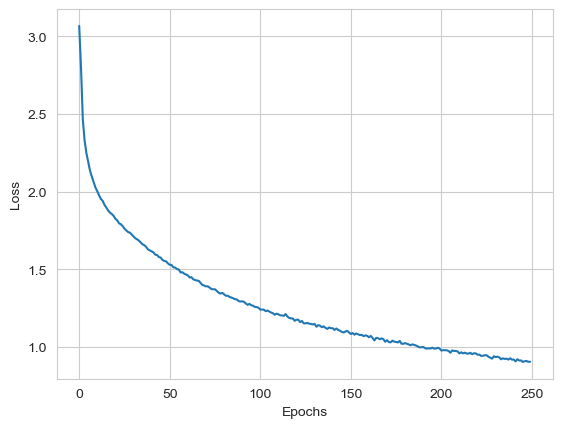

In [9]:
plt.figure()
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## Evaluate the model

In [10]:
def sample(preds, temperature=1.0):
    """Sample an index from a probability array"""
    
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    out = np.random.choice(range(len(chars)), p=probas.ravel())

    return out

def generate_output(length=500):
    """Prompt the user for input and generate a poem by transforming the model`s predictions into text"""

    generated = ''
    usr_input = input("Write the beginning of your poem, the Shakespeare machine will complete it. Your input is: ")
    sentence = ('{0:0>' + str(Tx) + '}').format(usr_input).lower() # zero pad the sentence to Tx characters
    generated += usr_input 

    sys.stdout.write("Here is your poem: \n\n") 
    sys.stdout.write(usr_input)

    for i in range(length):
        x_pred = np.zeros((1, Tx, len(chars)))

        for t, char in enumerate(sentence):
            if char != '0':
                x_pred[0, t, char_indexes[char]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature=1.0)
        next_char = indexes_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()

    sys.stdout.write("...")

In [11]:
generate_output()

Here is your poem: 

helloky ned:
my gefine and more my damined and me and,
the bul thee, though co all unless beaut,
so love a such abutire o'd my doth prow soull,
and in hour hangm the somn of the plawe stall fall.
tered's the world with that self betile seared,
and therchink grees with fortuse vistis pride,
and do i fail thee her as thy lime thence
i am wat be dost dome ponceivest of gree,
let me fool part us your self relime,
and my heart good the damp as theire me been,
and theis sheer not stor with exer bar, thise....